In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from time import time as ct
import random

pd.options.display.max_columns = None
pd.options.display.max_rows = None

%matplotlib inline

### Dowloading sample data

In [2]:
iris = pd.read_csv('https://raw.githubusercontent.com/mwaskom/seaborn-data/master/iris.csv')

In [3]:
iris.head()

,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa


In [4]:
# to get all object columns from our dataset
def obj_cols(df):
    '''
    This function returns the object columns in a given dataframe
    Parameters:
    	df (Pandas dataframe) : The dataframe in which to search for object columns

    Returns:
    	List of Object columns
    '''
    object_cols = df.select_dtypes(include = ['object']).columns
    if object_cols.shape[0]>0 : 
        print('Count of object columns: {}'.format(object_cols.shape[0]))
        return list(object_cols.values)
    else:
        print('No object columns in the dataframe!')
        return

In [5]:
obj_cols(iris)

Count of object columns: 1


['species']

In [6]:
def dataframe_null_report(df=None,null_pct_threshold=0):
    '''
    This function returns the fraction of nulls in each column of the dataframe based on a threshold specified as a fraction
    Parameters:
    	df (Pandas dataframe) : The dataframe for which you want to check the null % for each of its columns
    	null_pct_threshold (numeric) : Between 0 to 1. This is the minimum threshold on fraction nulls that wil be returned.
    									If no threshold is specified then it shows all columns with even in a single null.
    									Example: If 0.1 is specified then the function will return all columns which have >10% nulls.
    Returns:
    	Dataframe with all columns as rows which have fraction of nulls above the 'null_pct_threshold' with their % nulls value
    '''
    null_pct_df = pd.DataFrame(df.isna().sum(axis = 0)).reset_index()
    null_pct_df.columns = ['Variable','NullCount']
    null_pct_df['NullCountPct'] = null_pct_df['NullCount']/df.shape[0]
    null_pct_df.sort_values('NullCountPct',ascending=False,inplace=True)
    total_columns = df.shape[1]
    null_pct_df = null_pct_df[null_pct_df['NullCountPct']>null_pct_threshold]
    columns_with_10pct_nulls = null_pct_df.shape[0]
    print('Total Columns in Dataframe: {}'.format(total_columns))
    print('Columns with >{}% Nulls: {}'.format(null_pct_threshold*100,columns_with_10pct_nulls))
    return null_pct_df

In [7]:
dataframe_null_report(iris)

Total Columns in Dataframe: 5
Columns with >0% Nulls: 0


,Variable,NullCount,NullCountPct


### Univariate Exploration

In [8]:
def show_distribution(df=None,variable_name='',
                      pctl = [1, 10, 20, 25, 30 , 33, 40 , 50 , 60 , 67, 70, 75, 80 , 90 , 99], 
                      plot= True, bins = 50,
                      decimals_ = 2):
    '''
    This function shows the distribution (Histogram plot) of any variable and returns some important percentile values of the variable
    Parameters:
        df            : The pandas dataframe that contains this variable data
        varaible_name : String, Name of the variable for which the distribution should be shown
        pctl          : List of Percentile values that should be returned (1 to 100 in multiples of 1)
        plot          : Boolean, Default True; Will plot a histogram if set to True
        bins          : The number of bins into which the data should be plotted on the histogram
        decimals_     : # of decimals shown for the varaible
    '''
    percentil = df[variable_name].quantile(np.linspace(.01, 1, 99, 0), 'lower')
    op = percentil.to_frame().reset_index()
    op.index = op.index+1.
    op = op[op.index.isin(pctl)]
    op.rename(columns = {'index': 'Percentile'},inplace=True)
    op.loc[len(op.index)] = [0, df[variable_name].min()]
    op.loc[len(op.index)] = [1, df[variable_name].max()]
    op['Percentile'] = 'p_'+ (op['Percentile']*100).astype(int).astype(str).str.zfill(2)
    op.loc[len(op.index)] = ['AVG', df[variable_name].mean()]
    op.sort_values(by=[variable_name,'Percentile'],inplace = True)
    op.reset_index(inplace=True,drop=True)
    op[variable_name] = op[variable_name].round(decimals_)
    if plot == True:
        plt.figure(figsize = (20,8))
        sns.histplot(x=df[variable_name], bins = bins, kde= True)
    return op

,Percentile,sepal_width
0,p_00,2.00
1,p_01,2.20
2,p_10,2.50
3,p_20,2.70
4,p_25,2.80
5,p_30,2.80
6,p_33,2.90
7,p_40,3.00
8,p_50,3.00
9,AVG,3.06


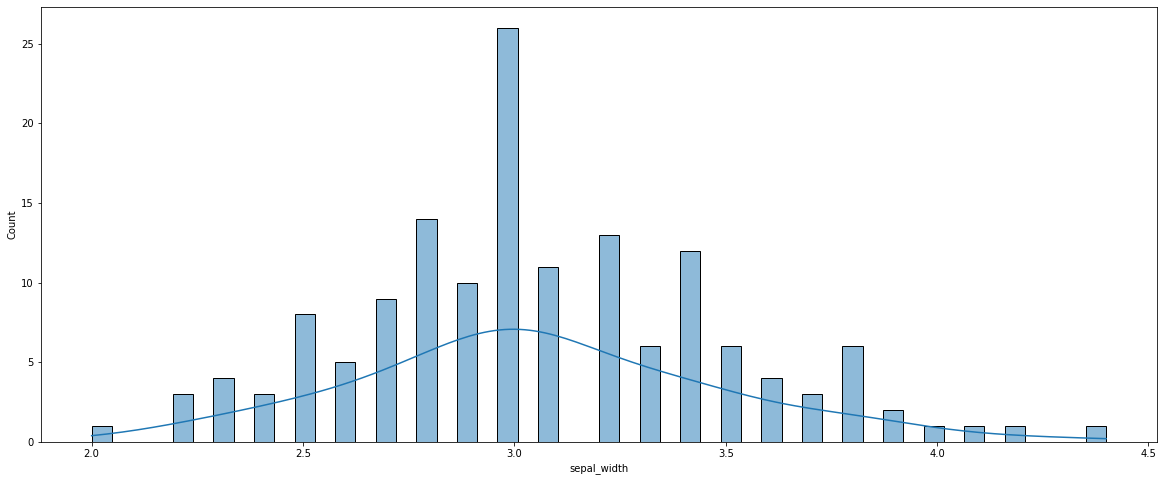

In [9]:
show_distribution(df=iris,variable_name='sepal_width',)

In [10]:
def show_distribution_multi_var(df=None,variable_names=[''],
                      pctl = [1, 10, 20, 25, 30 , 33, 40 , 50 , 60 , 67, 70, 75, 80 , 90 , 99], 
                      plot = True,
                      decimals_ = 2):
    '''
    This function shows the distribution (box-plots) of a list of variables and returns some important percentile values of the variable
    Parameters:
        df            : The pandas dataframe that contains this variable data
        varaible_name : List of strings, Names of the variables for which the distribution should be shown. If this is not provided, all numerical columns will be shown
        pctl          : List of Percentile values that should be returned (1 to 100 in multiples of 1)
        plot          : Boolean, Default True; Will plot a histogram if set to True
        decimals_     : # of decimals shown for the varaible
    '''
    if variable_names==['']: vars_ = df.select_dtypes(include='number').columns.values
    else: vars_ = variable_names
    list_ = []
    for v in vars_:
        percentil = df[v].quantile(np.linspace(.01, 1, 99, 0), 'lower')
        op = percentil.to_frame().reset_index()
        op.index = op.index+1.
        op = op[op.index.isin(pctl)]
        op.rename(columns = {'index': 'Percentile'},inplace=True)
        op.loc[len(op.index)] = [0, df[v].min()]
        op.loc[len(op.index)] = [1, df[v].max()]
        op['Percentile'] = 'p_'+ (op['Percentile']*100).astype(int).astype(str).str.zfill(2)
        op.loc[len(op.index)] = ['AVG', df[v].mean()]
        op.sort_values(by=[v,'Percentile'],inplace = True)
        op.reset_index(inplace=True,drop=True)
        op[v] = op[v].round(decimals_)
        list_.append(op)    
    #Box-Plots
    if plot == True:
        sns.boxplot(x="variable", y="value", data=pd.melt(df[vars_]), palette="Set3")
    from functools import reduce
    op_df = reduce(lambda df1,df2: pd.merge(df1,df2,on='Percentile'), list_)
    return op_df

,Percentile,sepal_width,sepal_length
0,p_00,2.00,4.30
1,p_01,2.20,4.40
2,p_10,2.50,4.80
3,p_20,2.70,5.00
4,p_25,2.80,5.10
5,p_30,2.80,5.20
6,p_33,2.90,5.40
7,p_40,3.00,5.60
8,p_50,3.00,5.80
9,AVG,3.06,5.84


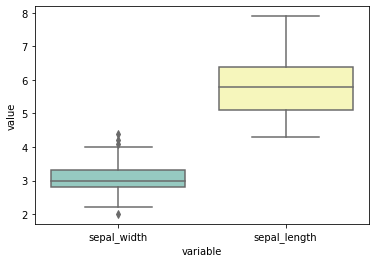

In [11]:
show_distribution_multi_var(df=iris,variable_names=['sepal_width','sepal_length'],)

,Percentile,sepal_length,sepal_width,petal_length,petal_width
0,p_00,4.30,2.00,1.00,0.1
1,p_01,4.40,2.20,1.10,0.1
2,p_10,4.80,2.50,1.40,0.2
3,p_20,5.00,2.70,1.50,0.2
4,p_25,5.10,2.80,1.60,0.3
5,p_30,5.20,2.80,1.70,0.4
6,p_33,5.40,2.90,1.90,0.6
7,p_40,5.60,3.00,3.90,1.1
8,p_50,5.80,3.00,4.30,1.3
9,AVG,5.84,3.06,3.76,1.2


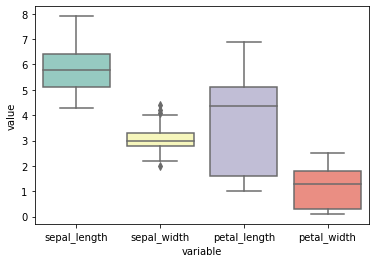

In [12]:
show_distribution_multi_var(df=iris)

In [13]:
def box_plots_univariate_by_category(df = None, numeric_var ='', categorical_var = '', categorical_var2 = '' ):
    '''
    This function creates box-plots for a single numeric variable divided by categorical variables.
    It allows for a secondary categorical variable 
    Parameters:
        df               : The dataframe which contains the data
        numeric_var      : The target numberic variable for which we are viewing the distribution
        categorical_var  : The categorical varibale by which the distribution is to be split (ideally not more than 5 categories)
        categorical_var2 : The categorical varibale by which the first category is further split (ideally not more than 3 categories)
    '''
    sns.set_style("whitegrid")
    plt.figure(figsize = (20,8))
    if categorical_var2 == '':
        ax = sns.boxplot(x=categorical_var, y=numeric_var, data=df, palette="Set2")
    else:
        ax = sns.boxplot(x=categorical_var, y=numeric_var, hue = categorical_var2, data=df, palette="Set2")

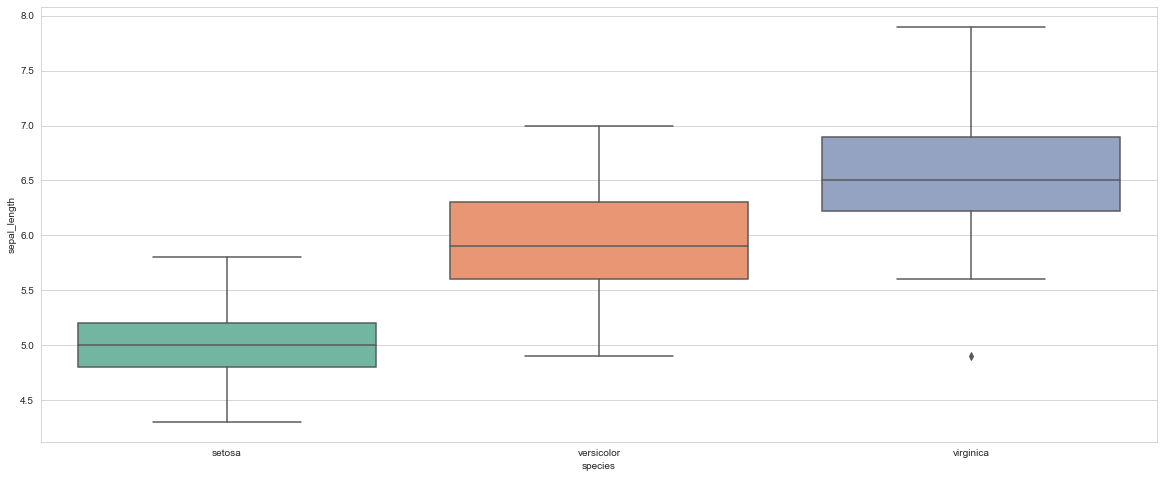

In [14]:
box_plots_univariate_by_category(iris,numeric_var='sepal_length',categorical_var='species',)

### Multi-variate Exploration

In [15]:
#Function returns a correlation of all other variables with specified target variable
def target_corr (df=None,target_var='',method=None):
    '''
    Function returns correlation of the target variable with all the remaining variables
    
    Parameters:
        df : The dataframe with all variables
        target_var : Variable that you wanty to check of all other vars with passed as a string
        method : 'pearson','kendall','spearman'
    
    Returns:
        Dataframe with 
    '''
    if method == None:
        method = 'pearson' 
    corr_name = method+'corr'
    df_corr = df.corr(method)
    var_corr = df_corr[target_var].to_frame()
    var_corr.rename({target_var:corr_name},axis=1,inplace = True)
    var_corr['abs_'+corr_name] = var_corr[corr_name].abs()
    var_corr.drop(target_var,axis=0, inplace=True)
    var_corr.sort_values('abs_'+corr_name,ascending=False,inplace=True)
    return var_corr

In [16]:
target_corr (iris,target_var='sepal_length')

,pearsoncorr,abs_pearsoncorr
petal_length,0.871754,0.871754
petal_width,0.817941,0.817941
sepal_width,-0.117570,0.117570


In [17]:
#Function to show correlation matrix between all variables
def corr_matrix (df=None,method=None,show_values = True, return_flag = False):
    '''
    Function returns correlation of all variables with each other
    
    Parameters:
        df          : The dataframe with all variables
        method      : 'pearson','kendall','spearman'; Default is 'pearson'
        show_values : Boolean, Default True
    
    Returns:
        Correlation Matrix dataframe, if return_flag set to True. Returns nothing by default
    '''
    if method == None:
        method = 'pearson' 
    corr_name = method+'corr'
    df_corr = df.corr(method)
    plt.figure(figsize = (12,10))
    if show_values == True: sns.heatmap(df_corr,cmap = 'coolwarm',annot=True)
    else: sns.heatmap(df_corr,cmap = 'coolwarm')
    
    if return_flag == True: return df_corr
    else : return

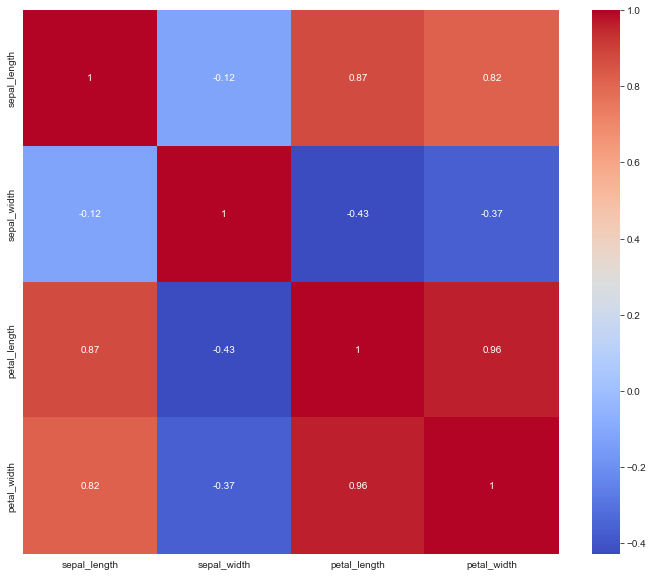

In [18]:
corr_matrix (iris,)

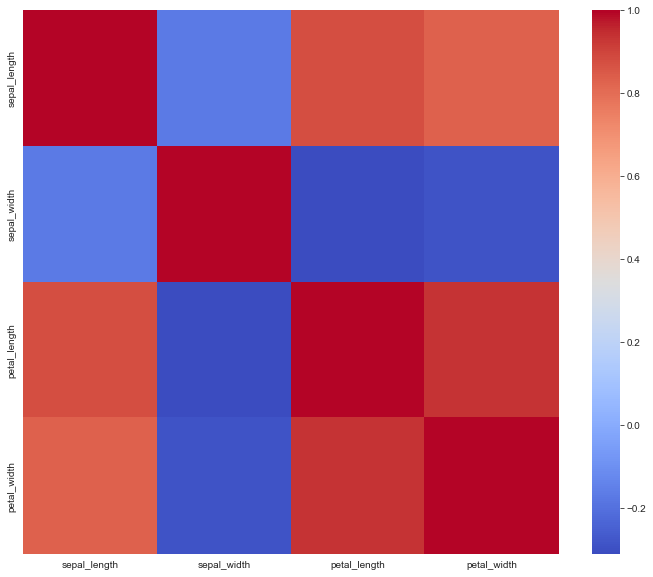

In [19]:
corr_matrix (iris,'spearman',False)